<font color='blue'> **Tidal Model** </font> 

In [1]:
import os; import flopy ; import matplotlib.pyplot as plt ; import pandas as pd ; import numpy as np ; import csv ; from pathlib import Path
from flopy.plot.styles import styles ; from shapely.geometry import Polygon     ; from flopy.utils.gridintersect import GridIntersect
_R = Path("_R")   ; _R.mkdir(exist_ok=True); TA = Path("_R/04_ex-gwf-advtidal"); TA.mkdir(exist_ok=True); TB = Path(TA/"TB"); TB.mkdir(exist_ok=True)
REF0=Path('E:/15_REPOS/00_BETAMI/bin/data_modflow6-examples/ex-gwf-advtidal')   ; sim_name = "TIDAL" 
REF1=(REF0/"tides.csv")   ;REF2=(REF0/"wellrates.csv")  ;REF3=(REF0/"riverstage.csv")  ;REF4=(REF0/"recharge1.csv") ; REF5=(REF0/"recharge2.csv")  ;REF6=(REF0/"recharge3.csv")

In [2]:
length_units = "meters" ;nlay = 3     ; ncol = 10 ;nrow = 15 ;delr = 500 ;delc = 500 ; top = 50 ; botm_str = "5.0 ,-10.0 ,-100.0"  ; icelltype_str = "1 ,0 ,0"
time_units = "days"     ;IC_strt = 50 ; ss = 0.000001 ;  sy = 0.2                               ; k11_str  = "5.0 ,0.1 ,4.0"       ; k33_str       = "0.5 ,5.0e-3 ,0.1"   
nouter=50;ninner=100;hclose=0.000000001;rclose=0.000001                                         ; nseg=3;etsurf=50;etrate=0.0004;depth = 10;pxdp=[0.2,0.5];petm = [0.3 ,0.1] 

botm = [float(value) for value in botm_str.split(",")]      ; k11 = [float(value) for value in k11_str.split(",")]
k33 = [float(value) for value in k33_str.split(",")]        ; icelltype = [int(value) for value in icelltype_str.split(",")]

nper = 4  ;perlen = [1.0, 10.0, 10.0, 10.0]    ;nstp = [1, 120, 120, 120]    ;tsmult = [1.0, 1.0, 1.0, 1.0]    ;TDIS=list(zip(perlen, nstp, tsmult))

days = np.sum(perlen) ; print('TDIS' ,TDIS, '         ___perlen', days, '(days)',   ',___nstp = 120' )
timprs = np.linspace(1, 10, 120, endpoint=True) ; np.savetxt(TB / "001_timprs.csv", timprs, delimiter=",")
#tw1=np.linspace(1,10,4,endpoint=True) ;tw2=np.linspace(11,20,4,endpoint=True) ;tw3=np.linspace(21,30,4,endpoint=True) ;print('T [1]',tw1,tw2,tw3)

TDIS [(1.0, 1, 1.0), (10.0, 120, 1.0), (10.0, 120, 1.0), (10.0, 120, 1.0)]          ___perlen 31.0 (days) ,___nstp = 120


In [3]:
def get_timeseries(fname, names, interpolation, filename=None):
    tsdata = []
    for row in np.genfromtxt(fname, delimiter=",", comments="#"):                   tsdata.append(tuple(row))
    TDIS2 = {"timeseries": tsdata,"time_series_namerecord": names,"interpolation_methodrecord": interpolation}
    if filename is not None: TDIS2["filename"] = filename
    return  TDIS2

In [4]:
wel_spd = {}
wel_spd[1] = [[0, 11, 2, -50, ""]               ,[2, 4, 7, "well_1_rate", "well_1"]  , [2, 3, 2, "well_2_rate", "well_2"]]
wel_spd[2] = [[2, 3, 2, "well_2_rate", "well_2"],[2, 4, 7, "well_1_rate", "well_1"]]
wel_spd[3] = [[2, 4, 7, "well_1_rate", "well_1"],[2, 3, 2, "well_2_rate", "well_2"]  , [0, 11, 2, -10, ""],[0, 2, 4, -20, ""],[0, 13, 5, -40, ""]]

pd.DataFrame.from_dict(wel_spd, orient='index', columns=['a', 'b','c','d','e']).to_csv  (TB / "06a_wel_n.csv")   
sa1 = pd.DataFrame(wel_spd[1]) ; sa2 = pd.DataFrame(wel_spd[2]) ; sa3 = pd.DataFrame(wel_spd[3])  ; pd.concat   ([sa1[:], sa2[:], sa3[:]], axis=1).to_csv (TB / "06b_wel_spd_all.csv") 
wel_ts = get_timeseries(REF2, ["well_1_rate", "well_2_rate", "well_6_rate"], 3 * ["stepwise"])    ; pd.DataFrame.from_dict(wel_ts, orient='index').to_csv (TB / "05a_wel_ts_n.csv")  
np.savetxt(TB/"05b_wel_ts.csv",wel_ts["timeseries"],delimiter = ",")                              # wel_ts 

In [5]:
ghb_spd = []  ;  ghb_spd += [[1, i, 9, "tides", 15.0  , "ESTUARY-L2"] for i in range(nrow)]
ghb_spd +=                  [[2, i, 9, "tides", 1500.0, "ESTUARY-L3"] for i in range(nrow)]   ; ghb_spd = {0: ghb_spd}  

ghb_spd2 = pd.DataFrame.from_dict(ghb_spd, orient='index') ; pd.DataFrame(ghb_spd[0]).to_csv (TB / "03d_ghb_spd.csv") ; print('ghb_spd, ghb_ts, ghb_OBS')

ghbobs_dict = {}  ;ghbobs_dict[f"{sim_name}.ghb.obs.csv"]=[("ghb_2_6_10","ghb",(1,5,9)),("ghb_3_6_10","ghb",(2,5,9)),("estuary2","ghb","ESTUARY-L2"),("estuary3","ghb","ESTUARY-L3")]
df = pd.DataFrame.from_dict(ghbobs_dict, orient='index')                 ; df1 = df.rename(columns = lambda x : 'a' + str(x))  # ; df1

dfa0 = df1['a0'].apply(pd.Series)  ;dfa1 = df1['a1'].apply(pd.Series)    ; dfa2 = df1['a2'].apply(pd.Series)     ; dfa3 = df1['a3'].apply(pd.Series)
df4 = pd.concat([dfa0[:], dfa1[:], dfa2[:], dfa3[:]], axis=1); df4.shape ; df4.columns = np.arange(12)           ; df5=df4.rename(columns=lambda x:'B'+str(x))
dg1 = df5['B2'].apply(pd.Series)   ;dg2  = df5['B5'].apply(pd.Series)    ; df6 = pd.concat([df5[:], dg1[:], dg2[:]], axis=1).to_csv (TB / "03c_ghb_obs.csv") 

ghb_ts = get_timeseries(REF1, "tides", "linear")  ; ghbobs_dict = {}   
ghbobs_dict[f"{sim_name}.ghb.obs.csv"] = [("ghb_2_6_10", "ghb", (1, 5, 9)),("ghb_3_6_10", "ghb", (2, 5, 9)),("estuary2", "ghb", "ESTUARY-L2"),("estuary3", "ghb" , "ESTUARY-L3"),]
pd.DataFrame.from_dict(ghb_ts, orient='index').to_csv (TB / "03a_ghb_ts_n.csv")      ; np.savetxt(TB/"03b_ghb_ts.csv",ghb_ts["timeseries"],delimiter = ",") ; ghb_ts;  # sa.tail()

ghb_spd, ghb_ts, ghb_OBS


In [6]:
rivrow = [2, 3, 4, 4, 5, 5, 5, 4, 4, 4, 9, 8, 7, 6, 6, 5, 5, 6, 6, 6]     ; rivcol = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
rivstg = 10 * ["river_stage_1"] + 10 * ["river_stage_2"]                        ; rivcnd = 2 * [1000 + f + 1 for f in range(10)]
rivrbt = list(np.linspace(35.9, 35.0, 10)) + list(np.linspace(36.9, 36.0, 10))  ; rivlay = 20 * [0]
rivbnd = (5 * [""]+ ["riv1_c6", "riv1_c7"]+ 3 * [""]+ 3 * ["riv2_upper"]+ 2 * [""]+ ["riv2_c6", "riv2_c7"]+ 3 * [""])  ;riv_spd = list(zip(rivlay, rivrow, rivcol, rivstg, rivcnd, rivrbt, rivbnd))
s2=pd.DataFrame(riv_spd); s2.columns = ['rivlay','rivrow','rivcol','rivstg','rivcnd','rivrbt','rivbnd']                ;s2.to_csv (TB/"07a_riv_spd.csv")  

riv_ts = get_timeseries(REF3,["river_stage_1", "river_stage_2"],["linear", "stepwise"])  ; np.savetxt(TB/"07b_riv_ts.csv",riv_ts["timeseries"],delimiter = ",")

row,col=np.where(np.zeros((nrow,ncol))==0) ;cellids=list(zip(nrow * ncol * [0], row, col))    ;evt_spd  = [[k, i, j, etsurf, etrate, depth, *pxdp, *petm] for k, i, j in cellids] 
s15=pd.DataFrame(evt_spd);  s15.columns = ['k','i','j','etsurf','etrate','depth','pxdpA','pxdpB','petmA','petmB'] ; s15.to_csv (TB/"09_evt_spd_.csv")   

hff = f"{sim_name}.hds"  ; bff = f"{sim_name}.cbc"
obsdict = {}  ; obslist = [["h1_13_8", "head", (2, 12, 7)]]    ; obsdict[f"{sim_name}.obs.head.csv"] = obslist
obslist = [["icf1", "flow-ja-face", (0, 4, 5), (0, 5, 5)]]     ; obsdict[f"{sim_name}.obs.flow.csv"] = obslist

<font color='blue'> **MODFLOW ____________________________________________________________________________________________________________** </font> 

In [7]:
sim = flopy.mf6.MFSimulation  (sim_name=sim_name,sim_ws=TA, verbosity_level=0)            ; flopy.mf6.ModflowTdis   (sim, nper=nper, perioddata=TDIS, time_units=time_units)
flopy.mf6.ModflowIms    (sim ,outer_maximum=nouter,outer_dvclose=hclose,inner_maximum=ninner,inner_dvclose=hclose,rcloserecord=f"{rclose} strict")
gwf = flopy.mf6.ModflowGwf     (sim, modelname=sim_name, save_flows=True)
flopy.mf6.ModflowGwfdis (gwf ,length_units=length_units,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=top,botm=botm)
flopy.mf6.ModflowGwfnpf (gwf ,cvoptions="perched",perched=True,icelltype=icelltype,k=k11,k33=k33,save_specific_discharge=True)   ; flopy.mf6.ModflowGwfic  (gwf ,strt=IC_strt)
flopy.mf6.ModflowGwfsto (gwf ,iconvert=1,ss=1.0e-6,sy=sy,steady_state={0: True},transient={1: True}) 
flopy.mf6.ModflowGwfwel (gwf ,stress_period_data=wel_spd ,boundnames=True   ,timeseries=wel_ts                            , pname="WEL") 
flopy.mf6.ModflowGwfghb (gwf ,stress_period_data=ghb_spd ,boundnames=True   ,timeseries=ghb_ts  ,observations=ghbobs_dict , pname="GHB-TIDAL")   
flopy.mf6.ModflowGwfriv (gwf ,stress_period_data=riv_spd ,boundnames=True   ,timeseries=riv_ts                            , pname="RIV")  
flopy.mf6.ModflowGwfevt (gwf ,nseg=nseg  ,stress_period_data=evt_spd                                                      , pname="EVT") ;                  

rchA = pd.read_csv(REF4) ; rchB = pd.read_csv(REF5) ; rchC = pd.read_csv(REF6) 
df = pd.concat([rchA, rchB.iloc[:,1], rchC.iloc[:,1]], axis=1)      ; df.columns=['index','z1','z2','z3'];df.to_csv (TB/"08a_RCH_spd_B.csv")                      

recharge_zone_1 = Polygon(shell=[(0, 0), (3000, 0), (3000, 5500), (1000, 7500), (0, 7500), (0, 0)])
recharge_zone_2 = Polygon(shell=[(1000, 7500), (3000, 5500), (5000, 7500), (1000, 7500)]) ; recharge_zone_3 = Polygon(shell=[(3000, 0), (5000, 0), (5000, 7500), (3000, 5500), (3000, 0)])

for ipak, p in enumerate([recharge_zone_1, recharge_zone_2, recharge_zone_3]) : 
    ix = GridIntersect(gwf.modelgrid, method="vertex", rtree=True)            ; result = ix.intersect(p)     ; rch_spd = []
    for i in range(result.shape[0]):
        rch_spd.append([0,*result["cellids"][i],f"rch_{ipak + 1}",result["areas"][i] / delr / delc])

    rch_ts = get_timeseries(REF5,[f"rch_{ipak + 1}"],["stepwise"] , filename=f"{sim_name}.rch{ipak + 1}.ts")  
    np.savetxt(TB/"08b_RCH_ts_.csv",rch_ts["timeseries"],delimiter = ",")              ; pd.DataFrame(rch_spd).to_csv (TB/ "08c_3.3_rch_spd.csv")

    flopy.mf6.ModflowGwfrch(gwf,stress_period_data=rch_spd ,boundnames=True , timeseries=rch_ts         ,fixed_cell=True,print_input=True  ,print_flows=True , save_flows=True , 
                            auxiliary=["MULTIPLIER"]       ,auxmultname="MULTIPLIER", pname=f"RCH-ZONE_{ipak + 1}" , filename=f"{sim_name}.rch{ipak + 1}")
    
flopy.mf6.ModflowGwfoc(gwf ,head_filerecord=hff ,budget_filerecord=bff ,saverecord=[("HEAD", "ALL"), ("BUDGET", "ALL")])
obs = flopy.mf6.ModflowUtlobs(gwf, print_input=False, continuous=obsdict)     ; sim.write_simulation(silent=True)  ; sim.run_simulation(silent=True)  

(True, [])

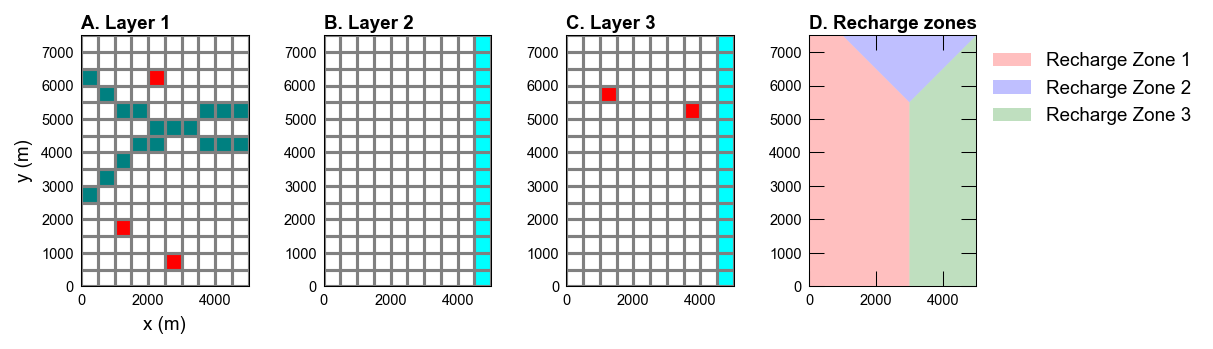

In [8]:
REC=[(recharge_zone_1,"r"), (recharge_zone_2, "b"), (recharge_zone_3, "g")]
with styles.USGSMap():                                  
    fig = plt.figure(figsize=(8, 10),dpi=150)
    ax = fig.add_subplot(441, aspect="equal") ;pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=0) ; pmv.plot_grid() ; pmv.plot_bc(name="WEL", kper=3) ; pmv.plot_bc(name="RIV")  # Wel, RIV
    title = "Layer 1" ; letter=chr(ord("@")+1);styles.heading(letter=letter,heading=title,ax=ax);ax.set_xlabel("x (m)");ax.set_ylabel("y (m)") # _______________________
    ax = fig.add_subplot(442, aspect="equal") ;pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=1) ; pmv.plot_grid() ; pmv.plot_bc(name="GHB") ; pmv.plot_bc(ftype="WEL", kper=3) # GHB
    title = "Layer 2" ; letter = chr(ord("@") + 2) ; styles.heading(letter=letter, heading=title, ax=ax)   # ___________________________________________________________
    ax = fig.add_subplot(443, aspect="equal") ;pmv = flopy.plot.PlotMapView(model=gwf, ax=ax, layer=2) ; pmv.plot_grid() ; pmv.plot_bc(name="GHB") ; pmv.plot_bc(ftype="WEL", kper=3) # GHB, WEL
    title = "Layer 3" ; letter = chr(ord("@") + 3) ; styles.heading(letter=letter, heading=title, ax=ax)   # ___________________________________________________________
    ax = fig.add_subplot(444, aspect="equal") ;pmv = flopy.plot.PlotMapView(model=gwf, ax=ax) ; pmv.plot_grid(linewidth=0)        
    for ip, (p, fc) in enumerate(REC):         xs, ys = p.exterior.xy ; ax.fill(xs, ys, alpha=0.25, fc=fc, label=f"Recharge Zone {ip + 1}")
    styles.graph_legend(ax) ; title = "Recharge zones" ; letter = chr(ord("@") + 4) ; styles.heading(letter=letter, heading=title, ax=ax); ax.legend(bbox_to_anchor=(1.0, 1.0)) ; plt.show() 

<font color='orange'> **RES ____________________________________________________________________________________________________________** </font> 

In [9]:
obsnames = gwf.obs[1].output.obs_names           ;print('obsnames:  ', obsnames)               ; tsdata1=gwf.obs[1].output.obs(f=obsnames[0])  ;ts1=tsdata1.data ;ts1na=ts1.dtype.names[1:]
tsdata2  = gwf.obs[1].output.obs(f=obsnames[1])  ;ts2=tsdata2.data;ts2na=ts2.dtype.names[1:]   ; tsdata3=gwf.ghb.output.obs()                  ;ts3=tsdata3.data ;ts3na=ts3.dtype.names[1:]
#print('ts.names_   ts1:',ts1na, '   ts2:', ts2na, '   ts3:', ts3na)                           ; print('tsdata 1-3:', tsdata3.__dict__.keys())

obsnames:   ['TIDAL.obs.head.csv', 'TIDAL.obs.flow.csv']


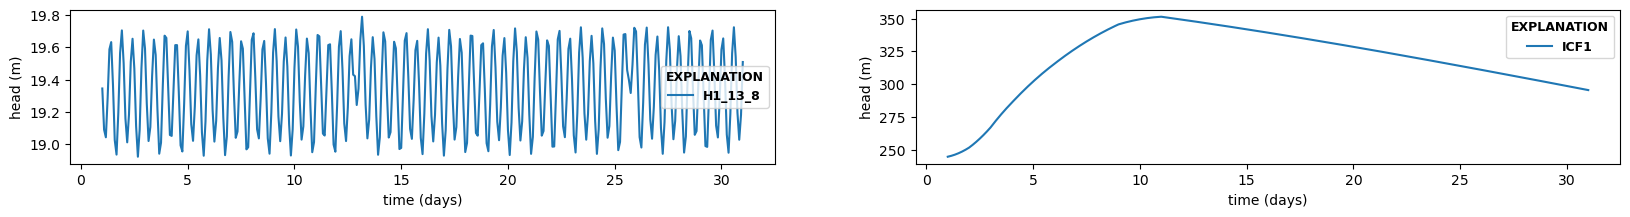

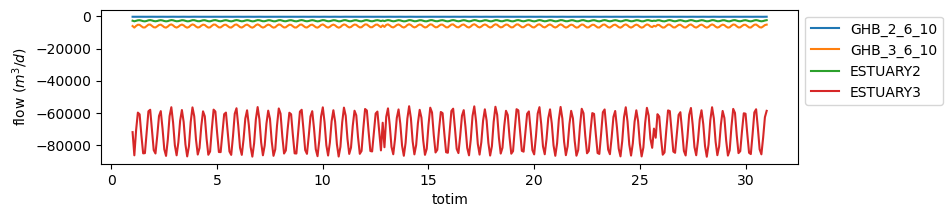

In [10]:
fig = plt.figure(figsize=(20, 2),dpi=100)       
ax=fig.add_subplot(121); ts_na=ts1na    ;ax.plot(ts1['totim']   ,ts1['H1_13_8'],label=ts_na)  ;ax.set_xlabel("time (days)") ; ax.set_ylabel("head (m)") ; styles.graph_legend(ax) 
ax=fig.add_subplot(122); ts_na = ts2na  ;ax.plot(ts1['totim']   ,ts2['ICF1'],label=ts_na)     ;ax.set_xlabel("time (days)") ; ax.set_ylabel("head (m)") ; styles.graph_legend(ax) ; plt.show()   
df = pd.DataFrame(ts3) ; ax = df.plot(x="totim", y= list(ts3na) , kind="line", rot=0, figsize=(9,2)) ; ax.legend(bbox_to_anchor=(1.0, 1.0)); ax.set(ylabel="flow ($m^3/d$)"); plt.show()

In [11]:
#df.head(); list(ts3na)